# <center>L1-based models for Sparse Signals<center>

本示例比较了三个基于L1回归模型的合成信号，该合成信号是从稀疏和相关的特征中获得的，这些特征进一步被加性高斯噪声污染

* a [Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso);
* an [Automatic Relevance Determination - ARD](https://scikit-learn.org/stable/modules/linear_model.html#automatic-relevance-determination);自动相关性判定
* an [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net).弹性网

当数据维度增加时，由于不相关变量与相关变量相关性不高，Lasso估计与模型选择估计越接近。在存在相关特征的情况下，Lasso本身无法选择正确的稀疏模式[1]。

在这里，我们比较了三个模型在R2分数、拟合时间和估计系数的稀疏性方面的性能，并与真实值进行了比较。

## Generate synthetic dataset

生成合成数据集

我们生成了一个样本数量低于特征总数的数据集。这导致了一个欠定系统，即解不是唯一的，因此我们不能应用普通的最小二乘法。正则化在目标函数中引入了一个惩罚项，它修正了优化问题，有助于缓解系统的欠定性质。

目标y是正弦信号交替符号的线性组合。在X的100个频率中，只有最低的10个用于生成y，而其余的特征没有信息。这导致了高维稀疏特征空间，其中需要某种程度的L1惩罚。

In [53]:
import numpy as np

rng = np.random.RandomState(0)
n_samples, n_features, n_informative = 50, 100, 10
time_step = np.linspace(-2, 2, n_samples)
freqs = 2 * np.pi * np.sort(rng.rand(n_features)) / 0.01
X = np.zeros((n_samples, n_features))

for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step)

idx = np.arange(n_features)
true_coef = (-1) ** idx * np.exp(-idx / 10)
true_coef[n_informative:] = 0  # sparsify coef
y = np.dot(X, true_coef)

Some of the informative features have close frequencies to induce (anti-)correlations.

一些信息特征具有相近的频率，从而产生(反)相关性。

In [54]:
freqs[:n_informative]

array([ 2.9502547 , 11.8059798 , 12.63394388, 12.70359377, 24.62241605,
       37.84077985, 40.30506066, 44.63327171, 54.74495357, 59.02456369])

我们使用numpy.random引入了随机阶段。将Random_sample和一些高斯噪声(由numpy.random.normal实现)添加到特征和目标中。

In [55]:
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step + 2 * (rng.random_sample() - 0.5))
    X[:, i] += 0.2 * rng.normal(0, 1, n_samples)

y += 0.2 * rng.normal(0, 1, n_samples)

这种稀疏、噪声和相关的特征可以从监测某些环境变量的传感器节点中获得，因为它们通常根据其位置注册相似的值(空间相关性)。我们可以想象目标。

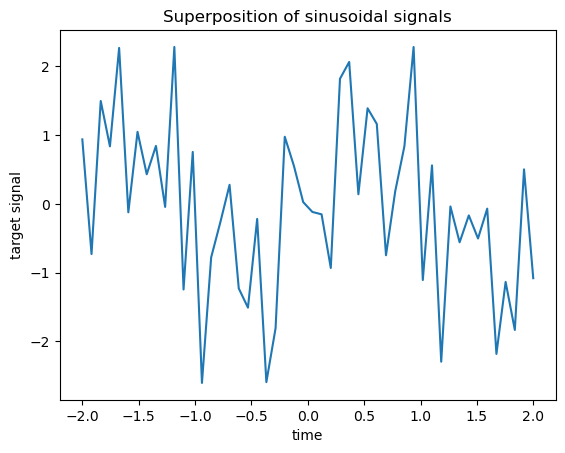

In [56]:
import matplotlib.pyplot as plt

plt.plot(time_step, y)
plt.ylabel("target signal")
plt.xlabel("time")
_ = plt.title("Superposition of sinusoidal signals")

为了简单起见，我们将数据分为训练集和测试集。在实践中，人们应该使用TimeSeriesSplit交叉验证来估计测试分数的方差。这里我们设置shuffle="False"，因为在处理具有时间关系的数据时，我们不能使用比测试数据成功的训练数据。

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

下面，我们根据拟合R<sup>2</sup>得分的优度和拟合时间来计算三个基于L1的模型的性能。然后我们画一个图来比较估计系数相对于真实系数的稀疏度，最后我们分析之前的结果

## Lasso

在这个例子中，我们演示了一个固定正则化参数alpha值的Lasso。在实践中，应该通过将时间分割交叉验证策略传递给LassoCV来选择最佳参数alpha。为了保持示例的简单和快速执行，我们在这里直接设置alpha的最佳值

In [58]:
from time import time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.004s
Lasso r^2 on test data : 0.480


## Automatic Relevance Determination (ARD)

ARD回归是Lasso的贝叶斯版本。如果需要，它可以对所有参数产生区间估计，包括误差方差。当信号含有高斯噪声时，它是一种很好的选择。

See the example [Comparing Linear Bayesian Regressors](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html#sphx-glr-auto-examples-linear-model-plot-ard-py) for a comparison of ARDRegression and BayesianRidge regressors.

In [59]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")

y_pred_ard = ard.predict(X_test)
r2_score_ard = r2_score(y_test, y_pred_ard)
print(f"ARD r^2 on test data : {r2_score_ard:.3f}")

ARD fit done in 0.164s
ARD r^2 on test data : 0.542


## ElasticNet

ElasticNet介于Lasso和Ridge之间，因为它结合了L1和L2-penalty。正则化的数量由两个超参数l1_ratio和alpha控制。对于l1_ratio = 0，惩罚是纯L2，模型等价于Ridge。类似地，l1_ratio = 1是纯L1惩罚项，模型等价于Lasso。对于0 < l1_ratio < 1，惩罚值是L1和L2的组合。

和之前一样，我们使用固定的alpha和l1_ratio来训练模型。为了选择它们的最佳值，我们使用了ElasticNetCV，这里没有展示，以保持示例的简单性。

In [60]:
from sklearn.linear_model import ElasticNet

t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.5).fit(X_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

ElasticNet fit done in 0.004s
ElasticNet r^2 on test data : 0.636


## Plot and analysis of the results

In this section, we use a heatmap to visualize the sparsity of the true and estimated coefficients of the respective linear models.

在本节中，我们使用热图来可视化各自线性模型的真实系数和估计系数的稀疏性。

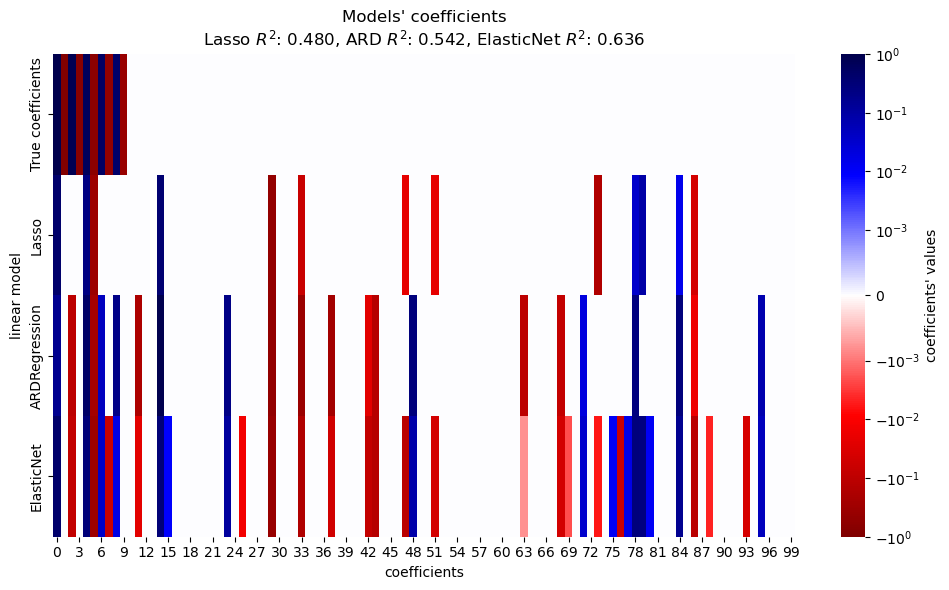

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import SymLogNorm

df = pd.DataFrame(
    {
        "True coefficients": true_coef,
        "Lasso": lasso.coef_,
        "ARDRegression": ard.coef_,
        "ElasticNet": enet.coef_,
    }
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-1, vmax=1),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.title(
    f"Models' coefficients\nLasso $R^2$: {r2_score_lasso:.3f}, "
    f"ARD $R^2$: {r2_score_ard:.3f}, "
    f"ElasticNet $R^2$: {r2_score_enet:.3f}"
)
plt.tight_layout()

In the present example ElasticNet yields the best score and captures the most of the predictive features, yet still fails at finding all the true components.  Notice that both ElasticNet and ARDRegression result in a less sparse model than a Lasso.

在本例中，ElasticNet获得了最好的分数，并捕获了大多数预测性特征，但仍然无法找到所有真实的组件。请注意，ElasticNet和ARDRegression的结果都比Lasso的模型稀疏。

## Conclusions

Lasso可以有效地恢复稀疏数据，但对于高度相关的特征效果不佳。事实上，如果几个相关的特征对目标有贡献，Lasso最终会选择其中一个。在特征稀疏但不相关的情况下，Lasso模型更适合。

ElasticNet在系数上引入了一些稀疏性，并将其值缩小为0。因此，在对目标有贡献的相关特征存在的情况下，模型仍然能够减少它们的权重，而不会将它们精确设置为零。这导致模型比纯Lasso更稀疏，并且可能捕获非预测性特征。

ARDRegression在处理高斯噪声时效果较好，但由于拟合先验信息，仍然无法处理相关特征，需要大量时间。